## **What Is Image Classification?**

* A type of classification problem where the task is to assign a label to an image from a predefined set of categories.
* The use of Convolutional Neural Networks (or CNNs) are the most common type of neural networks used when working with high-dimensional or complex data such as images, video or audio files.

#### **Imports**

* **For Installation**

In [1]:
try:
  import gdown
except:
  %pip install gdown
  import gdown

import zipfile
import os
import glob

* **Standard Dependencies**

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from PIL                 import Image
from IPython.display     import Image, clear_output
import random, re

plt.style.use('dark_background')

* ***scikit-learn* Dependencies**

In [3]:
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics         import classification_report, confusion_matrix, ConfusionMatrixDisplay

* ***TensorFlow* Dependencies**

In [4]:
import tensorflow                         as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models              import Model, Sequential
from tensorflow.keras.layers              import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications        import MobileNetV2

###**Data Extraction**

* **Downloading and Unzipping**


In [5]:
KIMESHAN_DIR = os.path.join(os.getcwd(), 'KIMESHAN_P')

if not os.path.exists(KIMESHAN_DIR):
  os.makedirs(KIMESHAN_DIR)

print('Download in progress...')
DRIVE_URL  = str('https://drive.google.com/uc?id=1h-eexfMMoszJ_xX26QJeBk0iVI5zQpwA')
ZIPPED_DIR = str(os.path.join(KIMESHAN_DIR, 'ZIPPED_CELEB_FOLDER.zip'))
gdown.download(DRIVE_URL, ZIPPED_DIR, quiet = True, use_cookies = False)

print('Extraction in progress...')
UNZIPPED_DIR = str(os.path.join(KIMESHAN_DIR, 'UNZIPPED_CELEB_FOLDER'))
with zipfile.ZipFile(ZIPPED_DIR, 'r') as ZIP_REF:
  ZIP_REF.extractall(UNZIPPED_DIR)
clear_output(wait = True)
print('Download and Extraction complete.')

if os.path.exists(ZIPPED_DIR):
  os.remove(ZIPPED_DIR)
else:
  pass

Download and Extraction complete.


### **Data Formatting**

* **Accessing Data from Subfolders**

In [6]:
MAIN_FOLDER = str(UNZIPPED_DIR + '/ST10437317_ICE_CNN_CELEB_IMAGES')
SUBFOLDERS  = [F.name for F in os.scandir(MAIN_FOLDER) if F.is_dir() and "_GIFS" not in F.name]

CELEB_LABELS = {}
for SUBFOLDER in SUBFOLDERS:
  CELEB_LABELS[SUBFOLDER] = []

del CELEB_LABELS['Tests']

for CELEB_KEY in CELEB_LABELS.keys():
  for IMG in glob.glob(f'{MAIN_FOLDER}/{CELEB_KEY}/*'):
    CELEB_LABELS[CELEB_KEY].append(IMG)

* **Creating a DataFrame**



In [7]:
DATA             = [(value, key) for key, values in CELEB_LABELS.items() for value in values]
DF               = pd.DataFrame(DATA, columns = ['Image_Directory', 'Celeb_Name'])
DF['Celeb_Name'] = DF['Celeb_Name'].str.replace('_', ' ')
DF               = DF.sample(frac = 1, random_state = 88).reset_index(drop = True)

DF.head(10)

,Image_Directory,Celeb_Name
0,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,The Rock
1,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,Nicolas Cage
2,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,Nicolas Cage
3,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,Nicolas Cage
4,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,The Rock
5,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,Nicolas Cage
6,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,The Rock
7,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,The Rock
8,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,Nicolas Cage
9,/content/KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10...,The Rock


###**Exploratory Data Analysis**

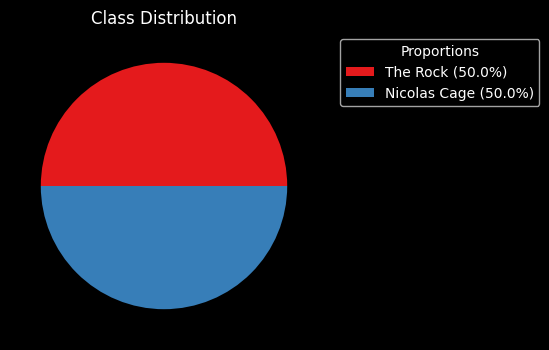

In [8]:
CELEB_COUNTS = DF['Celeb_Name'].value_counts()
LABELS      = [f'{label} ({percentage:.1f}%)' for label, percentage in zip(CELEB_COUNTS.index, CELEB_COUNTS / CELEB_COUNTS.sum() * 100)]

CELEB_COUNTS.plot(kind = 'pie', figsize = (20, 4), colors = sns.color_palette('Set1'), labels = None)
plt.title('Class Distribution')
plt.legend(title = 'Proportions', bbox_to_anchor = (1.05, 1), labels = LABELS)
plt.ylabel('')
plt.show()

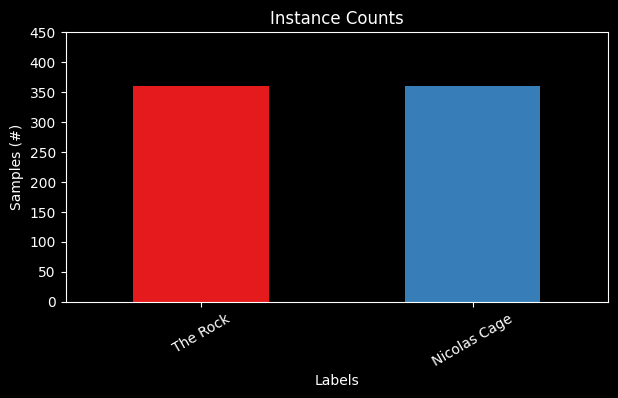

In [9]:
COLORS = sns.color_palette('Set1', len(CELEB_COUNTS))

CELEB_COUNTS.plot(kind = 'bar', figsize = (7, 3.5), color = COLORS)
plt.title('Instance Counts')
plt.xlabel('Labels')
plt.ylabel('Samples (#)')
plt.ylim(0, 450)
plt.xticks(rotation = 30)
plt.show()

* **Image Sample Previews**

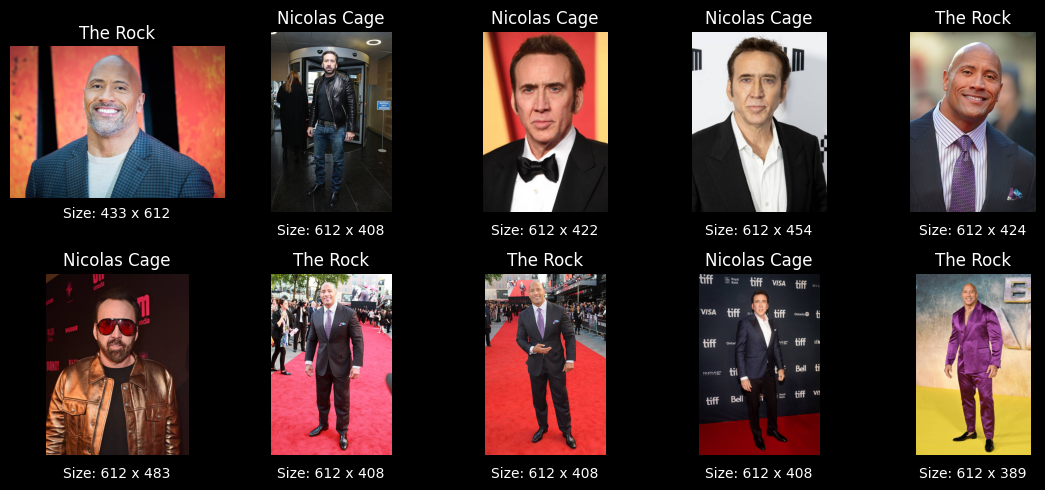

In [10]:
fig, axes = plt.subplots(2, 5, figsize = (11, 5))

for I, (IMG_DIR, CELEB) in enumerate(DF.head(10).values):
  ROW = I // 5
  COL = I % 5
  IMG = plt.imread(IMG_DIR)

  axes[ROW, COL].imshow(IMG)
  axes[ROW, COL].set_title(CELEB)
  axes[ROW, COL].axis('off')
  axes[ROW, COL].text(0.5, -0.1, f'Size: {IMG.shape[0]} x {IMG.shape[1]}', ha = 'center', va = 'center', transform = axes[ROW, COL].transAxes)

plt.tight_layout()
plt.show()

###**Train-Validation Splits**

In [11]:
TRAIN_SPLIT, VALID_SPLIT = train_test_split(DF, test_size = 0.2, random_state = 42, stratify = DF['Celeb_Name'])

len(TRAIN_SPLIT), len(VALID_SPLIT)

(576, 144)

###**Image Preprocessing**

In [12]:
TRAIN_GEN = ImageDataGenerator(rescale = 1. / 255).flow_from_dataframe(
              dataframe   = TRAIN_SPLIT,
              directory   = None,
              x_col       = 'Image_Directory',
              y_col       = 'Celeb_Name',
              target_size = (224, 224),
              batch_size  = 32,
              class_mode  = 'categorical',
              seed        = 42
            )

VALID_GEN = ImageDataGenerator(rescale = 1. / 255).flow_from_dataframe(
              dataframe   = VALID_SPLIT,
              directory   = None,
              x_col       = 'Image_Directory',
              y_col       = 'Celeb_Name',
              target_size = (224, 224),
              batch_size  = 32,
              class_mode  = 'categorical',
              seed        = 42
            )

Found 576 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.


### **User-Defined Functions**

* **Custom Model Training Function**

In [13]:
def TRAIN_MODEL(MODEL, N_EPOCHS, TRAIN_DATA = TRAIN_GEN, VALID_DATA = VALID_GEN, HISTORY_PLOTS = True):

  print("Training in progress...")
  HISTORY = MODEL.fit(TRAIN_DATA, validation_data = VALID_DATA, epochs = N_EPOCHS, verbose = 0)
  clear_output(wait = True)
  print("Training complete!")

  if(N_EPOCHS > 1):
    HISTORY_PLOTS = True
  else:
    HISTORY_PLOTS = False

  if (HISTORY_PLOTS == True):
    TRAIN_ACC  = HISTORY.history['accuracy']
    VALID_ACC  = HISTORY.history['val_accuracy']
    TRAIN_LOSS = HISTORY.history['loss']
    VALID_LOSS = HISTORY.history['val_loss']
    EPOCHS     = range(1, len(TRAIN_ACC) + 1)

    fig, axes = plt.subplots(1, 2, figsize = (12, 5))

    axes[0].plot(EPOCHS, TRAIN_ACC, label = 'Training')
    axes[0].plot(EPOCHS, VALID_ACC, label = 'Validation')
    axes[0].set_title('Accuracy Log')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(0.25, 1.00)
    axes[0].set_ylabel('Accuracy Factor')
    axes[0].set_xticks(EPOCHS)
    axes[0].legend()

    axes[1].plot(EPOCHS, TRAIN_LOSS, label = 'Training')
    axes[1].plot(EPOCHS, VALID_LOSS, label = 'Validation')
    axes[1].set_title('Loss Log')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('CCE Loss')
    axes[1].set_xticks(EPOCHS)
    axes[1].legend()

    for i in range(len(EPOCHS)):
      axes[0].text(EPOCHS[i], TRAIN_ACC[i], f'{TRAIN_ACC[i]:.2f}', ha = 'center', va = 'bottom', color = 'white')
      axes[0].text(EPOCHS[i], VALID_ACC[i], f'{VALID_ACC[i]:.2f}', ha = 'center', va ='bottom', color = 'white')

      axes[1].text(EPOCHS[i], TRAIN_LOSS[i], f'{TRAIN_LOSS[i]:.2f}', ha = 'center', va = 'bottom', color = 'white')
      axes[1].text(EPOCHS[i], VALID_LOSS[i], f'{VALID_LOSS[i]:.2f}', ha = 'center', va = 'bottom', color = 'white')

    plt.tight_layout()
    plt.show()

  else:
    return HISTORY

* **Custom Prediction Function**

In [14]:
def MAKE_PREDICTION(MODEL, IMG_PATH):

  def PRED_LABEL():
    IMG           = load_img(str(IMG_PATH), target_size = (224, 224))
    TEST_ARRAY    = np.expand_dims(img_to_array(IMG), axis = 0) / 255
    PREDICTION    = np.argmax(MODEL.predict(TEST_ARRAY))
    CLASS_INDICES = {v: k for k, v in VALID_GEN.class_indices.items()}
    PRED_LABEL    = CLASS_INDICES.get(PREDICTION)
    return PRED_LABEL

def MAKE_PREDICTION(MODEL, IMG_PATH):

  def PRED_LABEL():
    IMG           = load_img(str(IMG_PATH), target_size = (224, 224))
    TEST_ARRAY    = np.expand_dims(img_to_array(IMG), axis = 0) / 255
    PREDICTION    = np.argmax(MODEL.predict(TEST_ARRAY))
    CLASS_INDICES = {v: k for k, v in VALID_GEN.class_indices.items()}
    PRED_LABEL    = CLASS_INDICES.get(PREDICTION)
    return PRED_LABEL

  LABEL     = PRED_LABEL()
  KEY       = re.search(r'\((.*?)\)', IMG_PATH).group(1)
  GIF_FOL   = str('KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10437317_ICE_CNN_CELEB_IMAGES/_GIFS/')
  GIF_FOL_2 = str('KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10437317_ICE_CNN_CELEB_IMAGES/_GIFS_WRONG/')

  if LABEL == 'Nicolas Cage':
    GIF = GIF_FOL + '(1).gif'
  else:
    GIF = GIF_FOL + '(2).gif'

  print(f"MODEL: It's {LABEL}!")

  if(LABEL == 'Nicolas Cage' and KEY == '1') or (LABEL == 'The Rock' and KEY == '2'):
    print('COMMENT: This is correct, good job :)')
    return Image(GIF)
  else:
    print(f"COMMENT: Sorry, that ain't {LABEL}, fam :(")
    if(LABEL == 'Nicolas Cage'):
      return Image(GIF_FOL_2 + '(2).gif')
    else:
      return Image(GIF_FOL_2 + '(1).gif')

###**Model Setup**

* `MODEL_0` **Setup**

In [15]:
MODEL_0 = Sequential([
                      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
                      tf.keras.layers.MaxPooling2D((2, 2)),
                      tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                      tf.keras.layers.MaxPooling2D((2, 2)),
                      tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
                      tf.keras.layers.MaxPooling2D((2, 2)),
                      tf.keras.layers.Flatten(),
                      tf.keras.layers.Dense(2, activation = 'softmax')
                    ])

MODEL_0.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* `MODEL_1` **Setup**

In [16]:
BASE    = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
X       = BASE.output
X       = GlobalAveragePooling2D()(X)
X       = Dense(1024, activation = 'relu')(X)
PREDS   = Dense(2, activation = 'softmax')(X)
MODEL_1 = Model(inputs = BASE.input, outputs = PREDS)

MODEL_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Model Training**

* `MODEL_0` **Training**

Training complete!


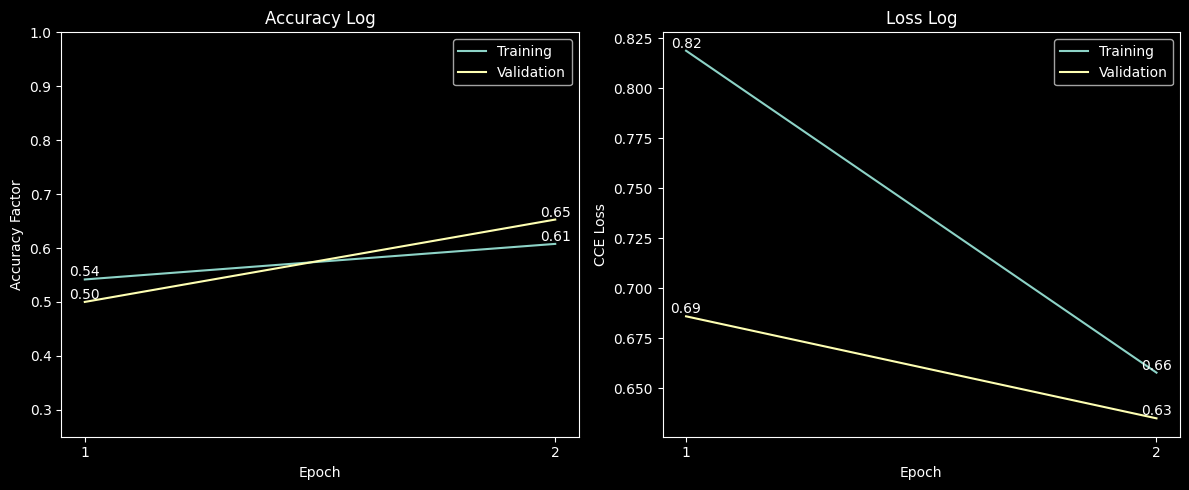

In [17]:
TRAIN_MODEL(MODEL_0, N_EPOCHS = 2)

* `MODEL_1` **Training**

Training complete!


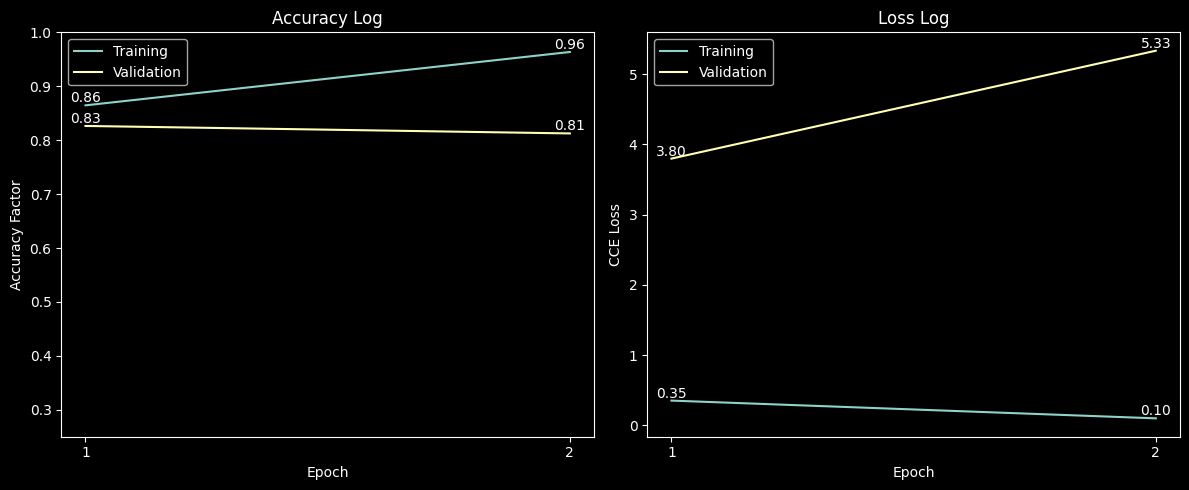

In [18]:
TRAIN_MODEL(MODEL_1, N_EPOCHS = 2)

* **Final Thoughts**

###**New Image(s) Predictions**


* **Nicolas Cage Test Image:**

<img src = 'https://lumiere-a.akamaihd.net/v1/images/p_nationaltreasure2bookofsecrets_19895_8713f371.jpeg' width = "270" height = "405">

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
MODEL: It's Nicolas Cage!
COMMENT: This is correct, good job :)


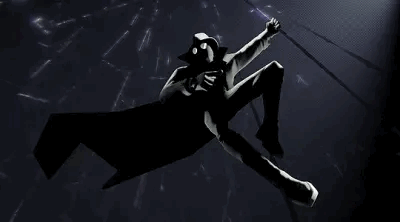

In [19]:
MAKE_PREDICTION(MODEL_1, 'KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10437317_ICE_CNN_CELEB_IMAGES/Tests/(1).jpeg')

* **Dwayne Johnson Test Image:**

<img src = 'https://www.shutterstock.com/editorial/image-editorial/MbT2A51bO0TaIb14MzY2NDU=/jumanji-next-level-2019-poster-art-dwayne-440nw-10506502z.jpg'>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MODEL: It's The Rock!
COMMENT: This is correct, good job :)


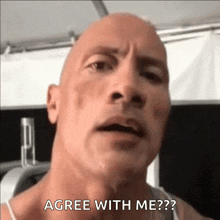

In [20]:
MAKE_PREDICTION(MODEL_1, 'KIMESHAN_P/UNZIPPED_CELEB_FOLDER/ST10437317_ICE_CNN_CELEB_IMAGES/Tests/(2).jpg')

***fin*** 🥐